<a href="https://colab.research.google.com/github/fatwaman/Learning_Python/blob/main/Capstone_Project_Fatwa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CAPSTONE PROJECT FATWA RAFIUDIN**

## **1. LOAD LIBRARIES AND DATASET**

### 1.1. Import Necessary Libraries and Dataset

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re #regex

# Import dataset which still in sql file (MySQL)
from google.colab import files
upload = files.upload()
file_path = 'datatransaksi.sql'

Saving datatransaksi.sql to datatransaksi.sql


### 1.2 Convert Dataset to JSON format

In [2]:
def parse_mysql_insert(file_path):
    """
    Parses a MySQL .sql file, extracts data from INSERT statements, and returns a list of dictionaries.
    """
    data = []
    # Regex to find the values inside the `values(...)` part of an INSERT statement
    pattern = re.compile(r"values\((.*?)\);")

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            # Check for INSERT statements
            if line.startswith("insert into `laporan`"):
                match = pattern.search(line)
                if match:
                    values_string = match.group(1)
                    # Split the string by single quotes and commas to get individual values
                    # The regex splits by a comma followed by a single quote, which is more robust
                    # than a simple comma split for cases where values might contain commas.
                    values = re.findall(r"'([^']*)'", values_string)

                    # Convert values to the correct data types based on the table schema
                    # id: int, id_user: int, tanggal: varchar, jumlah_transaksi: int, jumlah_total: float
                    record = {
                        "id": int(values[0]),
                        "id_user": int(values[1]),
                        "tanggal": values[2],
                        "jumlah_transaksi": int(values[3]),
                        "jumlah_total": float(values[4])
                    }
                    data.append(record)
    return data

# Replace 'datatransaksi.sql' with the actual path to your file
parsed_data = parse_mysql_insert(file_path)

# Print the parsed data
import json
print(json.dumps(parsed_data[:5], indent=4)) # Print Top 5 JSON Result


[
    {
        "id": 5,
        "id_user": 51,
        "tanggal": "2017-03-02",
        "jumlah_transaksi": 0,
        "jumlah_total": 0.0
    },
    {
        "id": 6,
        "id_user": 51,
        "tanggal": "2017-03-01",
        "jumlah_transaksi": 0,
        "jumlah_total": 0.0
    },
    {
        "id": 11,
        "id_user": 51,
        "tanggal": "2017-03-06",
        "jumlah_transaksi": 0,
        "jumlah_total": 0.0
    },
    {
        "id": 15,
        "id_user": 2854,
        "tanggal": "2017-03-07",
        "jumlah_transaksi": 1,
        "jumlah_total": 100000.0
    },
    {
        "id": 18,
        "id_user": 51,
        "tanggal": "2017-03-07",
        "jumlah_transaksi": 0,
        "jumlah_total": 0.0
    }
]


### 1.3 Convert JSON Parsing to Pandas Dataframe

In [3]:
# Converts it into a pandas DataFrame. Table-like structure similar to a spreadsheet or a table in a database
df = pd.DataFrame(parsed_data)
df.head()

,id,id_user,tanggal,jumlah_transaksi,jumlah_total
0,5,51,2017-03-02,0,0.0
1,6,51,2017-03-01,0,0.0
2,11,51,2017-03-06,0,0.0
3,15,2854,2017-03-07,1,100000.0
4,18,51,2017-03-07,0,0.0


## **2. DATA CLEANING**

### 2.1 Rename Column and Check Important Column

In [6]:
# Column standardization and date parsing

# Read as a string so that date parsing can be controlled
df = pd.DataFrame(parsed_data)

# Rename column name to english version
rename_map = {
    'tanggal': 'date',
    'jumlah_transaksi': 'number of transactions',
    'jumlah_total': 'total_amount'
}
df.rename(columns = rename_map, inplace = True)
#df = df.rename(columns={c:e for c,e in rename_map.items() if c in df.columns})

# Check important columns and raise error if found
required = {'id_user', 'date', 'total_amount'}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Required column is missing: {missing}. Please check your sql file.")

### 2.2 Tidy Up Column Name

In [7]:
# Tidy up column name (trim the name and make all lowercase)
df.columns = df.columns.str.strip().str.lower()

# Check id_user columnn and convert to string
df['id_user'] = df['id_user'].astype(str).str.strip()

# Check total_amount columnn and convert to numeric
df['total_amount'] = pd.to_numeric(df['total_amount'], errors='coerce')

### 2.3 Date Cleaning and Standardization

In [8]:
# Parsing date ensures all its values are treated as strings and trim the value
s = df['date'].astype(str).str.strip()

# Change date separator from "." or "/" to "-"
s = s.str.replace(r'[./]', '-', regex=True)

# Check common date pattern
mask_ymd   = s.str.match(r'^\d{4}-\d{1,2}-\d{1,2}$')   # YYYY-MM-DD
mask_dmy   = s.str.match(r'^\d{1,2}-\d{1,2}-\d{4}$')   # DD-MM-YYYY
mask_8dig  = s.str.match(r'^\d{8}$')                   # YYYYMMDD

date_nya = pd.Series(pd.NaT, index=s.index, dtype='datetime64[ns]')
date_nya[mask_ymd]  = pd.to_datetime(s[mask_ymd],  format='%Y-%m-%d', errors='coerce')
date_nya[mask_dmy]  = pd.to_datetime(s[mask_dmy],  format='%d-%m-%Y', errors='coerce')
date_nya[mask_8dig] = pd.to_datetime(s[mask_8dig], format='%Y%m%d',   errors='coerce')
rest = ~(mask_ymd | mask_dmy | mask_8dig)
date_nya[rest] = pd.to_datetime(s[rest], errors='coerce', dayfirst=True)

df['date'] = date_nya

df.head()

,id,id_user,date,number of transactions,total_amount
0,5,51,2017-03-02,0,0.0
1,6,51,2017-03-01,0,0.0
2,11,51,2017-03-06,0,0.0
3,15,2854,2017-03-07,1,100000.0
4,18,51,2017-03-07,0,0.0


## **3. IMPLEMENT LARGE LANGUAGE MODEL (LLM)**

### 3.1 Install LLM from Replicate (replicate.com)

In [9]:
# Install llm
!pip install replicate
!pip install langchain_community

### 3.2 Set Up API Token and Model Environment

In [10]:
from langchain_community.llms import Replicate
from google.colab import userdata
import os

# Set the API token
api_token = userdata.get("api_token")
os.environ['REPLICATE_API_TOKEN'] = api_token

# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
llm = Replicate(
    model=model,
    replicate_api_token=api_token,
)

### 3.3 Give Order to LLM and Try the Result

In [11]:
output = llm.invoke("in what date which have highest total_amount and what is the value? please make python script")
print(output)

To solve this problem, we'll assume you have a pandas DataFrame named `df` with a column named `total_amount` and a column named `date`. The script will find the date with the highest `total_amount` and print both the date and the value.

Here's the Python script using pandas:

```python
import pandas as pd

# Assuming df is your DataFrame and it has columns 'date' and 'total_amount'
max_amount_date = df['date'][df['total_amount'].idxmax()]
max_amount = df['total_amount'].max()

print(f"The date with the highest total_amount is {max_amount_date} and the value is {max_amount}.")
```

This script first finds the index of the maximum value in the `total_amount` column using `idxmax()`. It then uses this index to extract the corresponding date from the `date` column. Finally, it prints the date and the maximum value.

Make sure you have the pandas library installed. If not, you can install it using:

```bash
pip install pandas
```

Replace `df` with your actual DataFrame name in the script

In [20]:
# Group by 'date' and sum 'total_amount'
grouped = df.groupby('date')['total_amount'].sum().reset_index()

# Find the date with the maximum total_amount
max_amount_date = grouped.loc[grouped['total_amount'].idxmax()]
max_amount_value = grouped['total_amount'].max()

print(f"The date with the highest total_amount is {max_amount_date['date']} and the value is {max_amount_value}.")

The date with the highest total_amount is 2018-06-10 00:00:00 and the value is 101087209796.2.


In [21]:
output = llm.invoke(f"I want to see datatransaksi in bar chart for total_amount per year, please make python script")
print(output)

To create a bar chart for the total_amount per year from a dataset named `datatransaksi`, you can use the libraries `pandas` for data manipulation and `matplotlib` for visualization. Here's a Python script that assumes your data is in a CSV file with columns 'tanggal' (date) and 'total_amount'.

```python
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
# Assuming your CSV file is named 'datatransaksi.csv' and has columns 'tanggal' (date) and 'total_amount'
datatransaksi = pd.read_csv('datatransaksi.csv')

# Convert 'tanggal' column to datetime if it isn't already
datatransaksi['tanggal'] = pd.to_datetime(datatransaksi['tanggal'])

# Extract the year from the 'tanggal' column
datatransaksi['year'] = datatransaksi['tanggal'].dt.year

# Group the data by year and sum the 'total_amount'
yearly_total = datatransaksi.groupby('year')['total_amount'].sum().reset_index()

# Plot the data as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(yearly

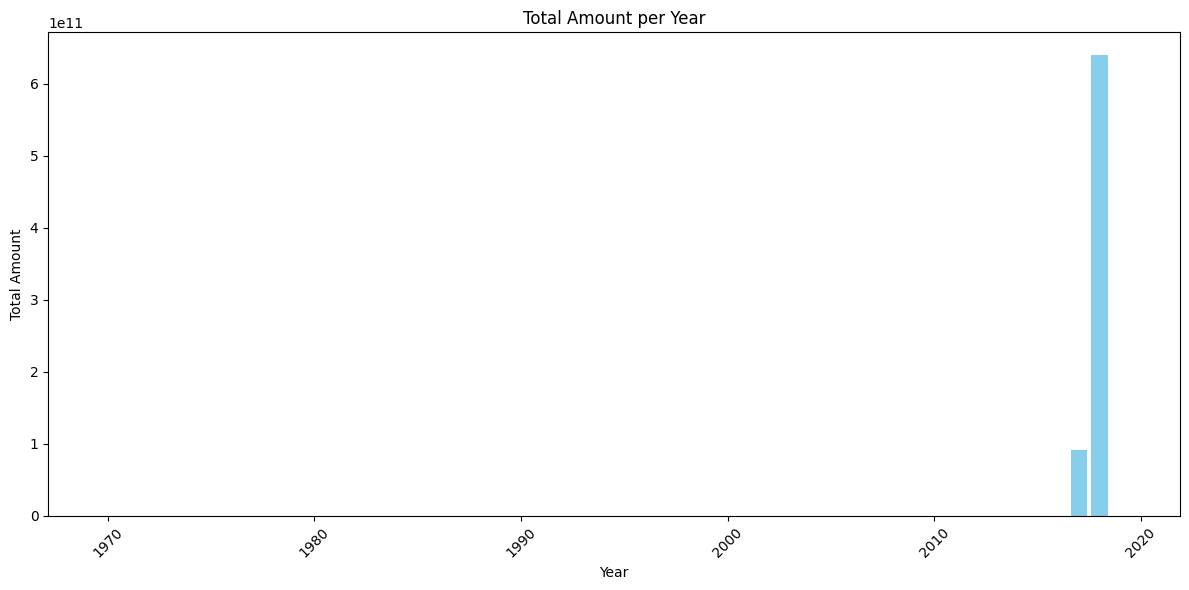

    year  total_amount
0   1970  8.020000e+05
1   2000  2.950000e+05
2   2009  8.000000e+03
3   2010  6.652000e+06
4   2012  2.760000e+05
5   2013  7.028500e+06
6   2014  1.400000e+04
7   2015  2.016050e+07
8   2016  3.852400e+07
9   2017  9.090494e+10
10  2018  6.391671e+11
11  2019  1.051000e+06


In [25]:
# Load your data
# Assuming your CSV file is named 'datatransaksi.csv' and has columns 'tanggal' (date) and 'total_amount'
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'tanggal' column
df['year'] = df['date'].dt.year

# Group the data by year and sum the 'total_amount'
yearly_total = df.groupby('year')['total_amount'].sum().reset_index()

# Plot the data as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(yearly_total['year'], yearly_total['total_amount'], color='skyblue')

# Add title and labels
plt.title('Total Amount per Year')
plt.xlabel('Year')
plt.ylabel('Total Amount')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

print(yearly_total)

In [ ]:
output = llm.invoke("Using the provided datatransaksi, conduct a monthly cohort analysis to determine how long users retain the transaction feature. Ensure that only transactions with total_transactions > 0 are counted.")
print(output)

## **4. COHORT PREPARATION**

### 3.1 Filter Data

In [ ]:
# Filter valid data which are not NaT (Not a Time) or NoN (Not a Number) and total_amount > 0
df = df.dropna(subset=['date', 'id_user', 'total_amount']) # Filter exclude NaT or NaN data
df = df[df['total_amount'] > 0] # Filter total_amount > 0

# Check if found years anomaly, in this data are take out < 2010
yrs = df['date'].dt.year
print("Date range is from:", df['date'].min(), "→", df['date'].max())
print("Number of rows which have year < 2010:", int((yrs < 2010).sum()), "row(s)")

In [ ]:
df = df[df['date'].dt.year >= 2015].reset_index(drop=True) # Resets the index to a clean sequence starting from 0
df[ df['date'].dt.year < 2015 ].head(10) # Quick check to see if any data from before the year 2000 still exists in the DataFrame after the filtering step

### 3.2 Define Transaction Month and Cohort Month

In [ ]:
# For transaction month and Cohort month, and aging
# Bulan transaksi & bulan cohort (gunakan Period → aman)
df['transaction_month']  = df['date'].dt.to_period('M').dt.to_timestamp()

first_tx = (df.groupby('id_user', as_index=False)['transaction_month']
              .min()
              .rename(columns={'transaction_month':'cohort_month'}))

df = df.merge(first_tx, on='id_user', how='left')

def month_diff(d1, d2):
    return (d1.dt.year - d2.dt.year) * 12 + (d1.dt.month - d2.dt.month)

df['cohort_index'] = month_diff(df['transaction_month'], df['cohort_month']) + 1
df.head()

### 3.3 Matrix Retention Calculation and Active User

In [ ]:
# Calculate Retension Matrix (Percentage)
# Active user per (cohort_month x cohort_index)
cohort_counts = (
    df.groupby(['cohort_month', 'cohort_index'])['id_user']
      .nunique()
      .reset_index(name='active_users')
)

# Cohort size = user on first month
cohort_sizes = (
    cohort_counts[cohort_counts['cohort_index'] == 1]
    .rename(columns={'active_users':'cohort_size'})[['cohort_month','cohort_size']]
)

cohort_counts = cohort_counts.merge(cohort_sizes, on='cohort_month', how='left')
cohort_counts['retention'] = cohort_counts['active_users'] / cohort_counts['cohort_size']

# Pivot → persen
retention_pct = (cohort_counts.pivot_table(
    index='cohort_month', columns='cohort_index',
    values='retention', aggfunc='mean'
).fillna(0) * 100).round(1)

retention_pct.index = retention_pct.index.strftime('%Y-%m')  # rapi
retention_pct.head()


### 3.4 Cohort Visualization

In [ ]:
# Visuzalization using Heatmap
# Limit the Column (optional so it's not too crowded)
N = 18  # ubah ke 12/18/24 sesuai kebutuhan
plot_df = retention_pct.copy()
plot_df = plot_df.loc[:, [c for c in plot_df.columns if c <= N]]

# Zero change to NaN to make white background & And zero value is not writen
plot_df = plot_df.replace(0, np.nan)

# Plot
h, w = max(4, 0.4*plot_df.shape[0]+2), max(8, 0.6*plot_df.shape[1]+2)
plt.figure(figsize=(w, h))
sns.set_style("white")

ax = sns.heatmap(
    plot_df, cmap="YlGnBu", annot=True, fmt=".1f",
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Retention (%)"},
    vmin=0, vmax=100
)
ax.set_xlabel("Month to-n since Cohort")
ax.set_ylabel("Cohort (YYYY-MM)")
ax.set_title("Cohort Retention Monthly (Transaction > 0)")
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)
plt.tight_layout()
plt.show()